Проект по предметот Податочно рударство

Изработиле: Јана Митровска (181080) и Бојан Петрушевски (162012)



# **Imports**

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import warnings
import pydot
warnings.filterwarnings("ignore")

from graphviz import *
from pomegranate import *
from sklearn import metrics, preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, LogisticRegression, ElasticNet, BayesianRidge, LassoLarsIC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, Birch, SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, classification_report, confusion_matrix, mean_squared_error, silhouette_score, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from scipy import stats
from operator import sub
from sklearn.decomposition import PCA
from IPython.display import display 
from wordcloud import WordCloud 



%matplotlib inline

from io import StringIO 
import re 
import gzip 
import urllib.request

In [69]:
data = pd.read_csv('/content/drive/MyDrive/netflix.csv')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,14-Aug-20,2020,TV-MA,4,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,23-Dec-16,2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,20-Dec-18,2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,16-Nov-17,2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,1-Jan-20,2008,PG-13,123,Dramas,A brilliant group of students become card-coun...
...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...",Sweden,19-Oct-20,2005,TV-MA,99,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...
7783,s7784,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2-Mar-19,2015,TV-14,111,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...
7784,s7785,Movie,Zulu Man in Japan,Unknown,Nasty C,Unknown,25-Sep-20,2019,TV-MA,44,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast..."
7785,s7786,TV Show,Zumbo's Just Desserts,Unknown,"Adriano Zumbo, Rachel Khoo",Australia,31-Oct-20,2019,TV-PG,1,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...


# **Upgrading the dataset**

In [7]:
# Download IMDB files from official repository
urllib.request.urlretrieve('https://datasets.imdbws.com/title.ratings.tsv.gz', 'title.ratings.tsv.gz');
urllib.request.urlretrieve('https://datasets.imdbws.com/title.basics.tsv.gz', 'title.basics.tsv.gz');

#extract files as text
with gzip.open('title.ratings.tsv.gz', 'rt', encoding='utf8') as reader:
    ratings_contents = reader.read()

with gzip.open('title.basics.tsv.gz', 'rt', encoding='utf8') as reader:
    basics_contents = reader.read()
    
# Create text strings to be loaded into panda.read_csv as a tab separated file
ratings_data = StringIO(ratings_contents)
basics_data = StringIO(basics_contents)

# Create pandas dataframe from tab separated file for ratings
imdb_ratings_df_raw = pd.read_csv(ratings_data, sep='\t', low_memory=False)

# Create pandas dataframe from tab separated file for titles
imdb_titles_df_raw = pd.read_csv(basics_data, sep='\t', low_memory=False)

# We will make a copy of our raw data, dropping any duplicate rows in the process
imdb_ratings_df = imdb_ratings_df_raw.copy().drop_duplicates()
imdb_titles_df = imdb_titles_df_raw.copy().drop_duplicates()

In [8]:
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1822
1,tt0000002,6.0,232
2,tt0000003,6.5,1576
3,tt0000004,6.1,151
4,tt0000005,6.2,2399


In [9]:
imdb_titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [10]:
idf = pd.merge(imdb_titles_df.set_index('tconst'), imdb_ratings_df.set_index('tconst'), left_index=True, right_index=True, how='inner').drop_duplicates()

In [11]:
idf.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.7,1822
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.0,232
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1576
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",6.1,151
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.2,2399


In [12]:
idf = idf[idf.startYear.apply(lambda x: str(x).isnumeric())]
idf['startYear'] = idf['startYear'].astype(int)

In [13]:
data['title'] = data['title'].str.lower()
idf['primaryTitle'] = idf['primaryTitle'].str.lower()

In [14]:
df = pd.merge(data, idf, left_on=['title', 'release_year'], right_on=['primaryTitle', 'startYear'], how='inner').drop_duplicates().reset_index()
df = df.drop('index', axis=1)
df = df.drop('show_id', axis=1)

In [15]:
df

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,23-Dec-16,2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,movie,7:19,7:19,0,2016,\N,94,"Drama,History",5.9,621
1,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,20-Dec-18,2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",movie,23:59,23:59,0,2011,\N,78,Horror,4.6,931
2,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,16-Nov-17,2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",movie,9,9,0,2009,\N,79,"Action,Adventure,Animation",7.1,136323
3,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,16-Nov-17,2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",short,9,9,0,2009,\N,9,"Comedy,Drama,Short",5.4,90
4,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,1-Jan-20,2008,PG-13,123,Dramas,A brilliant group of students become card-coun...,movie,21,21,0,2008,\N,123,"Crime,Drama,History",6.8,238004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,Movie,zoo,Shlok Sharma,"Shashank Arora, Shweta Tripathi, Rahul Kumar, ...",India,1-Jul-18,2018,TV-MA,94,"Dramas, Independent Movies, International Movies",A drug dealer starts having doubts about his t...,tvEpisode,zoo,Zoo,0,2018,\N,\N,"Animation,Comedy,Family",7.2,5
6316,Movie,zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,11-Jan-20,2006,PG,88,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",movie,zoom,Zoom,0,2006,\N,93,"Action,Adventure,Comedy",4.4,20440
6317,Movie,zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...",Sweden,19-Oct-20,2005,TV-MA,99,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...,movie,zozo,Zozo,0,2005,\N,105,"Drama,Family,War",6.6,3151
6318,Movie,zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,2-Mar-19,2015,TV-14,111,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,movie,zubaan,Zubaan,0,2015,\N,115,Drama,6.1,428


In [16]:
type(df['date_added'].iloc[0])

str

In [17]:
df = df[df.date_added.isna() == False].reset_index()
df = df.drop("index", axis=1)

In [18]:
netflix = df[['type', 'title', 'director', 'cast', 'date_added', 'rating', 'description', 'isAdult', 'startYear', 'endYear', 'country', 'duration', 'averageRating', 'numVotes']]

In [71]:
netflix

,type,title,director,cast,date_added,rating,description,isAdult,startYear,endYear,country,duration,averageRating,numVotes
0,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",23-Dec-16,TV-MA,After a devastating earthquake hits Mexico Cit...,0,2016,\N,Mexico,93,5.9,621
1,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",20-Dec-18,R,"When an army recruit is found dead, his fellow...",0,2011,\N,Singapore,78,4.6,931
2,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",16-Nov-17,PG-13,"In a postapocalyptic world, rag-doll robots hi...",0,2009,\N,United States,80,7.1,136323
3,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",16-Nov-17,PG-13,"In a postapocalyptic world, rag-doll robots hi...",0,2009,\N,United States,80,5.4,90
4,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",1-Jan-20,PG-13,A brilliant group of students become card-coun...,0,2008,\N,United States,123,6.8,238004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,Movie,zoo,Shlok Sharma,"Shashank Arora, Shweta Tripathi, Rahul Kumar, ...",1-Jul-18,TV-MA,A drug dealer starts having doubts about his t...,0,2018,\N,India,94,7.2,5
6316,Movie,zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",11-Jan-20,PG,"Dragged from civilian life, a former superhero...",0,2006,\N,United States,88,4.4,20440
6317,Movie,zozo,Josef Fares,"Imad Creidi, Antoinette Turk, Elias Gergi, Car...",19-Oct-20,TV-MA,When Lebanon's Civil War deprives Zozo of his ...,0,2005,\N,Sweden,99,6.6,3151
6318,Movie,zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",2-Mar-19,TV-14,A scrappy but poor boy worms his way into a ty...,0,2015,\N,India,111,6.1,428


# **Missing values and outliers**

In [28]:
# checking for null values
netflix.isnull().sum()

type             0
title            0
director         0
cast             0
date_added       0
rating           0
description      0
isAdult          0
startYear        0
endYear          0
country          0
duration         0
averageRating    0
numVotes         0
dtype: int64

In [29]:
print(netflix['type'].unique())

['Movie' 'TV Show']


In [30]:
print(netflix['isAdult'].unique())

['0' '1']


In [31]:
print(netflix['rating'].unique())

['TV-MA' 'R' 'PG-13' 'TV-14' 'NR' 'TV-G' 'TV-PG' 'TV-Y' 'UR' 'TV-Y7' 'PG'
 'G' 'TV-Y7-FV' 'NC-17']


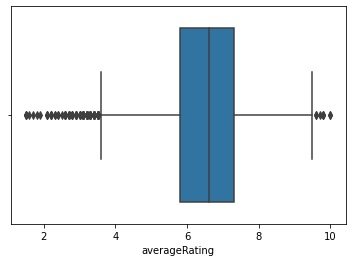

In [32]:
sns.boxplot(x=netflix['averageRating'])

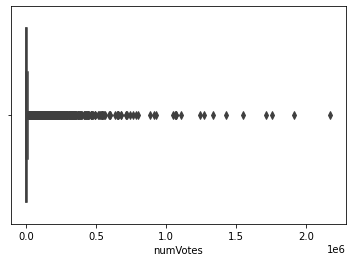

In [33]:
sns.boxplot(x=netflix['numVotes'])

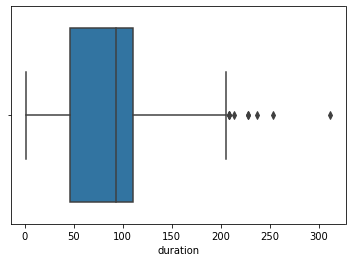

In [34]:
sns.boxplot(x=netflix['duration'])

In [35]:
netflix.to_csv('netflix-expanded.csv')

# **EDA**

In [ ]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '00000000'

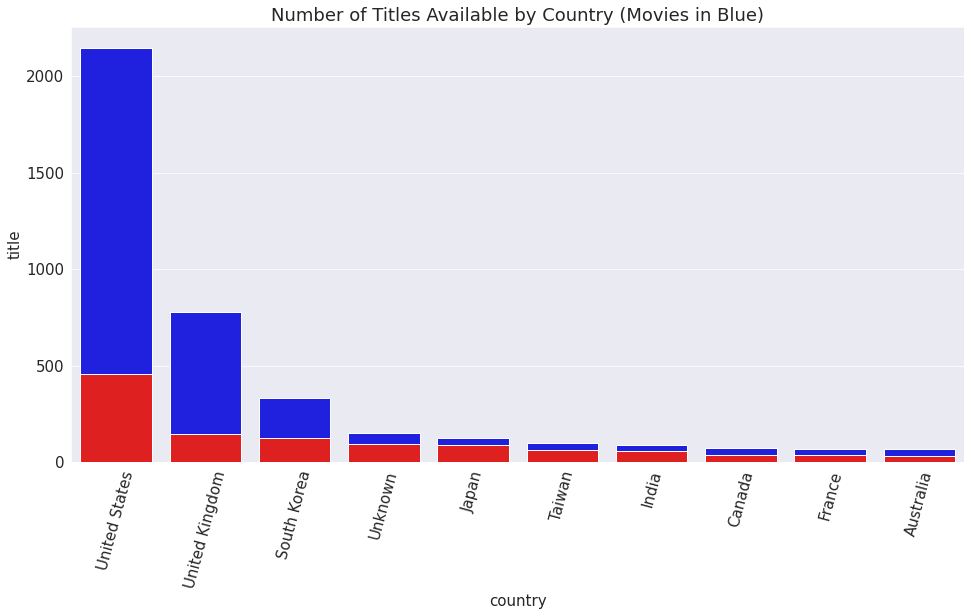

In [ ]:
xplt = netflix[netflix["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = netflix[netflix["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)

xplt2 = netflix[netflix["type"] == "TV Show"].groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt2 = netflix[netflix["type"] == "TV Show"].groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)

plt.figure(figsize=(16, 8))
plt.fontsize = 20
plt.xticks(rotation=75)
plt.title(label='Number of Titles Available by Country (Movies in Blue)')
plt.xlabel("Country")
plt.ylabel("Number of Titles")
sns.barplot(x=xplt, y=yplt, color="Blue");
sns.barplot(x=xplt2, y=yplt2, color="Red");


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.pie(values=netflix['type'].value_counts(), 
             names=netflix['type'].value_counts().index, 
             title='Number total of TV-Shows and Movies in Netflix')
fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.pie(values=netflix['rating'].value_counts(), 
             names=netflix['rating'].value_counts().index, 
             title='Rating of TV-Shows and Movies in Netflix')
fig.show()

In [ ]:
fig = px.bar(x = netflix[netflix['type']=='TV Show']['duration'].value_counts().index, 
             y = netflix[netflix['type']=='TV Show']['duration'].value_counts())

fig.update_layout(
    title='Duration of TV Shows',
    xaxis_title="Duration (seasons)",
    yaxis_title="Total number",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1)
)

fig.show()

In [ ]:
director_df = netflix.groupby(["country", "rating", "director"]).agg({"averageRating":"mean", "title":"count"}).reset_index()
director_df = pd.DataFrame(director_df[(director_df["director"] != "Unknown") & (director_df["title"] >= 5)].groupby("director")["averageRating"].mean().sort_values(ascending=False)).reset_index().head(10)
director_df.style.hide_index()

director,averageRating
Peter Jackson,8.166667
Taika Waititi,8.020000
Quentin Tarantino,7.987500
Anthony Russo,7.740000
Martin Scorsese,7.711111
Philippe Aractingi,7.700000
Mike Flanagan,7.600000
Mohammed Alhmly,7.585714
Ryan Coogler,7.366667
Oyefunke Fayoyin,7.320000


# **Decision trees**

Партиционирање на податоците во подмножества кои содржат инстанци со слични вредности и користење на ентропија (која ни врати подобри резултати од gini index). Поставуваме вредност од 6 за max depth за максимална длабочина на дрвото, за да немаме overfitting на моделот.

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth = 6)

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)
data_encoded.head()

,type,title,director,cast,date_added,rating,description,isAdult,startYear,endYear,country,duration,averageRating,numVotes
0,0,90,1470,1130,703,8,1004,0,64,33,39,89,43,554
1,0,50,1034,4384,586,5,5003,0,59,33,57,74,30,773
2,0,91,2728,1277,382,4,2780,0,57,33,71,76,55,3527
3,0,91,2728,1277,382,4,2780,0,57,33,71,76,38,85
4,0,45,2518,2086,36,4,97,0,56,33,71,119,52,3660


In [ ]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [ ]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
predicted = dt.predict(X_test)

In [ ]:
result_data = pd.DataFrame({"actual":Y_test, "predicted":predicted})

In [ ]:
result_data

,actual,predicted
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0
...,...,...
1259,0,0
1260,0,0
1261,0,0
1262,0,0


970 примероци се предвиделе како 0 и биле 0 (true negative).

1 примерок се предвидол како 0 бил 1 (false positive). 

1 примерок се предвидол како 1 и бил 0 (false negative).

292 примероци се предвиделе како 1 и биле 1 (true positive).

In [ ]:
confusion_matrix = pd.crosstab(result_data['actual'], result_data['predicted'], rownames={'Actual'},
                               colnames=['Predicted'])
print(confusion_matrix) 
print(classification_report(Y_test, predicted))

Predicted    0    1
Actual             
0          970    1
1            1  292
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       293

    accuracy                           1.00      1264
   macro avg       1.00      1.00      1.00      1264
weighted avg       1.00      1.00      1.00      1264



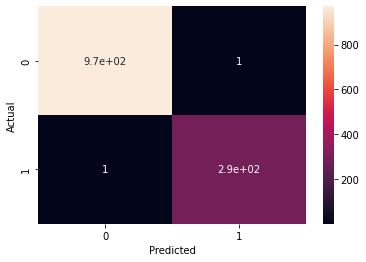

In [ ]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
print("Decision Tree evaluation\n")

ac = accuracy_score(result_data['actual'], result_data['predicted']) 
ps = precision_score(result_data['actual'], result_data['predicted']) 
rs = recall_score(result_data['actual'], result_data['predicted'])


print('accuracy of the model: ', ac)
print('precision score of the model: ',ps)
print('recall score of the model:',rs)

Decision Tree evaluation

accuracy of the model:  0.9984177215189873
precision score of the model:  0.9965870307167235
recall score of the model: 0.9965870307167235


# **Gaussian Naive Bayes Model**

Методот е варијант на наивен баесов класификатор, податоците треба да имаат нормална распределба и да се непрекинати.

In [ ]:
model = GaussianNB()
model.fit(X_train, Y_train.squeeze())

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)

In [ ]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [ ]:
model = GaussianNB()
model.fit(X_train, Y_train.squeeze())

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
result_data = pd.DataFrame({"actual":Y_test, "predicted":predicted})

In [ ]:
result_data

,actual,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1575,1,1
1576,1,1
1577,0,0
1578,1,1


1227 примероци се предвиделе како 0 и биле 0 (true negative).

0 примероци се предвиделе како 0 биле 1 (false positive). 

11 примероци се предвиделе како 1 и биле 0 (false negative).

342 примероци се предвиделе како 1 и биле 1 (true positive).

In [ ]:
confusion_matrix = pd.crosstab(result_data['actual'], result_data['predicted'], rownames={'Actual'}, colnames=['Predicted'])
print(confusion_matrix) 
print(classification_report(Y_test, predicted))

Predicted     0    1
Actual              
0          1227    0
1            11  342
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1227
           1       1.00      0.97      0.98       353

    accuracy                           0.99      1580
   macro avg       1.00      0.98      0.99      1580
weighted avg       0.99      0.99      0.99      1580



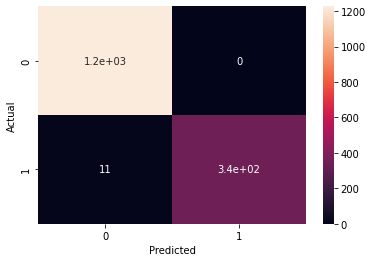

In [ ]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
print("Gaussian Model evaluation\n")

print (f"accuracy: {accuracy_score(actual,predicted)}\nprecision: {precision_score(actual, predicted)}\nrecall: {recall_score(actual, predicted)}")

Gaussian Model evaluation

accuracy: 0.9933533786991613
precision: 0.9992912827781715
recall: 0.9717436250861475


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 

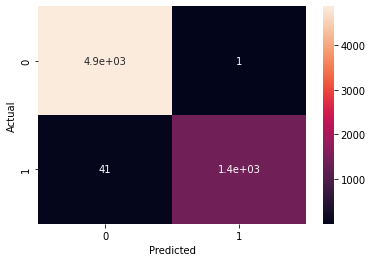

In [ ]:
#Обезбедува тренирање/тестирање на индекси, за да се раздели датата во тренирани/тестирани множества.
#Секој примерок се користи еднаш како тест множество додека останатиот дел го формираат тренираното множество.

loo = LeaveOneOut()

X = data_encoded.drop(['type'], axis = 1).to_numpy()
Y = data_encoded.type.to_numpy()

predicted = []
actual = []

for train_index, test_index in loo.split(X):
  trainX, testX = X[train_index], X[test_index]
  trainY, testY = Y[train_index], Y[test_index]

  model.fit(X_train, Y_train.squeeze())
  predicted_value = model.predict(testX)
  predicted.append(predicted_value[0])
  actual.append(testY[0])

print(predicted)
print(actual)

result_data = pd.DataFrame({"actual":actual, "predicted":predicted})
conf_matrix = pd.crosstab(result_data['actual'], result_data['predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

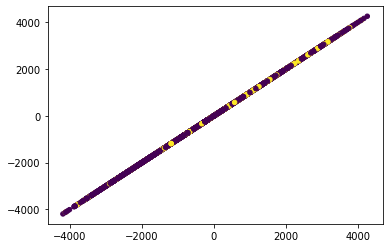

In [ ]:
#Крива која ја покажува прецизноста на Guassian Model
plt.scatter(X_pca[:,0], X_pca[:, :1], c=Y, s=20)

# **Bayesian Network**

Баесова мрежа е еден од најдобрите модели за графичко претставување на множеството на податоци, каде што секој јазол претставува случајна променлива и секое ребро ја преставува условната веројатност на соодветните случајни променливи.

In [ ]:
BNData = data[['type', 'country', 'director','release_year']].copy()

In [ ]:
model = BayesianNetwork.from_samples(BNData.to_numpy(), state_names= BNData.columns.values, algorithm='chow-liu')

In [ ]:
BNData.head()

,type,country,director,release_year
0,TV Show,Brazil,Unknown,2020
1,Movie,Mexico,Jorge Michel Grau,2016
2,Movie,Singapore,Gilbert Chan,2011
3,Movie,United States,Shane Acker,2009
4,Movie,United States,Robert Luketic,2008


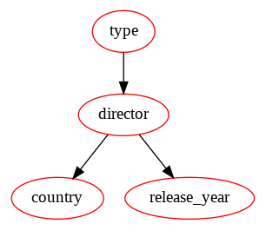

In [ ]:
#plot() функцијата се користи за да се создаде 2D шестоаголна парцела за обложување со точки во x и y.
#X и Y се параметрите на хоризонталните и вертикалните координати на податочните точки. 
model.plot()

In [ ]:
#sample() е вградена функција на рандом модул во Python што враќа конкретна должина на листа од елементи од некоја секвенца.
model.sample()

array([['Movie', 'France', 'Nabil Ayouch', '2015']], dtype='<U21')

In [ ]:
#predict(некои вредности) предвидува од предходно зададени периметри , вредности на  даден сет на податоци.
model.predict([['TV Show','France',None,None]])

[array(['TV Show', 'France', 'Unknown', 2020], dtype=object)]

# **KNN**

KNN ги класифицира новите податоци според сличноста со најблиските соседи, во нашиот случај ставивме вредност за n_neighbors за 10. 

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)

In [ ]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [ ]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)
knn_classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
y_pred = knn_classifier.predict(X_test)

1215 примероци се предвиделе како 0 и биле 0 (true negative).

12 примероци се предвиделе како 0 биле 1 (false positive). 

42 примероци се предвиделе како 1 и биле 0 (false negative).

311 примероци се предвиделе како 1 и биле 1 (true positive).

In [ ]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1205
           1       0.94      0.87      0.90       375

    accuracy                           0.96      1580
   macro avg       0.95      0.93      0.94      1580
weighted avg       0.96      0.96      0.96      1580



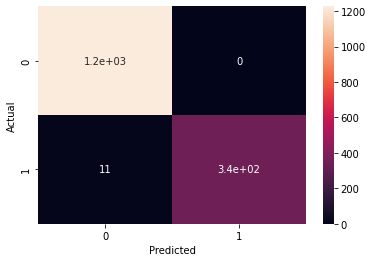

In [ ]:
sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
print("KNN evaluation\n")

ac = accuracy_score(Y_test, y_pred) 
ps = precision_score(Y_test, y_pred) 
rs = recall_score(Y_test, y_pred)


print('accuracy of the model: ', ac)
print('precision score of the model: ',ps)
print('recall score of the model:',rs)

KNN evaluation

accuracy of the model:  0.9556962025316456
precision score of the model:  0.9420289855072463
recall score of the model: 0.8666666666666667


In [ ]:
error = []

for i in range (1,40):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,Y_train)
  pred_i = knn.predict(X_test)
  error.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Mean Error')

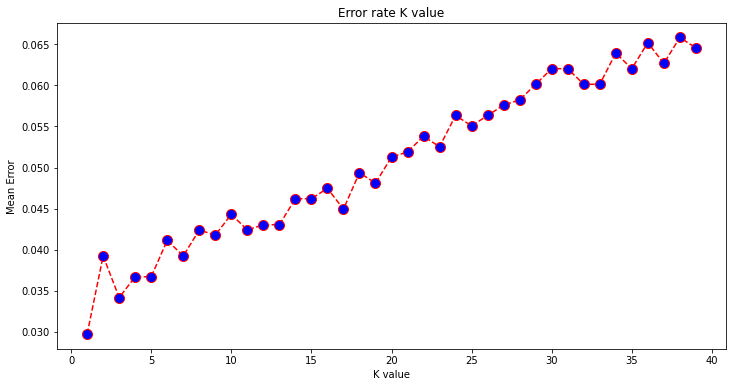

In [ ]:
#Анализа и графичко претставување на средната грешка на моделот за КНН класификаторот
plt.figure(figsize=(12,6))
plt.plot(range(1,40), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error rate K value')
plt.xlabel('K value')
plt.ylabel('Mean Error')

In [ ]:
error2 = []

for i in range (1,40):
  knn = KNeighborsClassifier(n_neighbors=i, metric="cosine")
  knn.fit(X_train,Y_train)
  pred_i = knn.predict(X_test)
  error2.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Mean Error')

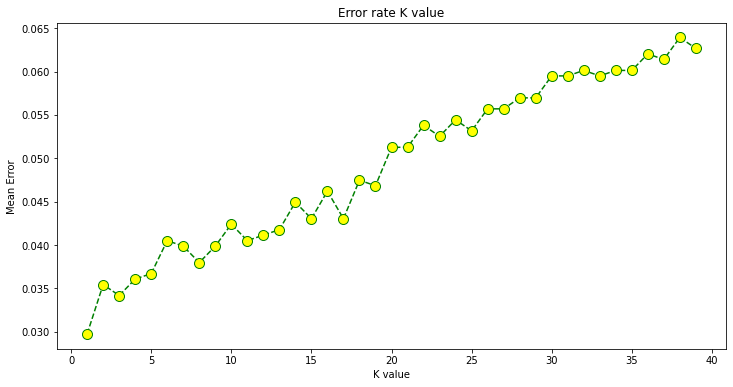

In [ ]:
#Анализа и графичко претставување на средната грешка на моделот за КНН класификаторот со косинусна метрика
plt.figure(figsize=(12,6))
plt.plot(range(1,40), error2, color='green', linestyle='dashed', marker='o', markerfacecolor='yellow', markersize=10)

plt.title('Error rate K value')
plt.xlabel('K value')
plt.ylabel('Mean Error')

# **Neural Network**

Keras е библиотека во python која што враќа брзи и лесни резултатите за модели за длабоко учење. Ја користиме оваа библиотека бидејќи во поголем број случаеви враќа најдобри резулати.

Имаме на влез 20372 колони, и поставуваме слој со 32 неврони. 
Исто така, додаваме hidden слој со 16 неврона, и излезен слој со еден неврон.


In [ ]:
X = netflix.drop(['type'], axis=1)
y = netflix.type.values

X = pd.get_dummies(X)
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [ ]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[0.255565, 0.289502, -0.498055, ..., -0.012582, -0.028143,
        -0.012582],
       [-0.326882, -0.019582, -1.568729, ..., -0.012582, -0.028143,
        -0.012582],
       [-0.559861, 0.021630, 0.490260, ..., -0.012582, -0.028143,
        -0.012582],
       [-0.559861, 0.021630, -0.827493, ..., -0.012582, -0.028143,
        -0.012582],
       [-0.676350, 0.907670, 0.243181, ..., -0.012582, -0.028143,
        -0.012582]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(32, input_dim=20372, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(16,kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=20)

Epoch 1/10
253/253 [==============================] - 3s 6ms/step - loss: 0.5458 - accuracy: 0.7669
Epoch 2/10
253/253 [==============================] - 2s 6ms/step - loss: 0.2701 - accuracy: 0.8465
Epoch 3/10
253/253 [==============================] - 2s 7ms/step - loss: 0.1034 - accuracy: 0.9933
Epoch 4/10
253/253 [==============================] - 2s 7ms/step - loss: 0.0220 - accuracy: 0.9998
Epoch 5/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0073 - accuracy: 1.0000
Epoch 6/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 7/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 8/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
253/253 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 10/10
253/253 [==============================] - 2s 6ms/step - loss: 7.3447e-04 - accuracy: 1.

In [ ]:
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

158/158 [==============================] - 1s 3ms/step - loss: 6.3454e-04 - accuracy: 1.0000
Accuracy: 100.00


In [ ]:
y_pred = model.predict(X_test)

931 примероци се предвиделе како 0 и биле 0 (true negative).

34 примероци се предвиделе како 0 биле 1 (false positive). 

99 примероци се предвиделе како 1 и биле 0 (false negative).

200 примероци се предвиделе како 1 и биле 1 (true positive).

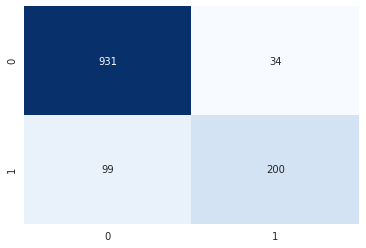

In [ ]:
cm = confusion_matrix(Y_test, y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

In [ ]:
print("Keras evaluation\n")

ac=accuracy_score(Y_test, y_pred.round())
ps = precision_score(Y_test, y_pred.round())
rs = recall_score(Y_test, y_pred.round())
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

Keras evaluation

accuracy of the model:  0.8947784810126582
precision score of the model:  0.8547008547008547
recall score of the model:  0.6688963210702341


# **XGBoost Classifier**

Го користиме Xgboost бидејќи враќа добри резултати кога има множеството на податоци каде што има мешавина од категориски и нумерички податоци (како што е во нашиот случај). 
Поставуваме вредност од 4 за max depth за да не биде многу комплексен моделот (да не дојде до  overfitting).
Поставуваме default вредност 1 за min_child_weight.
Поставуваме default вредност 10 за n_estimators.
Поставуваме вредност за n_jobs -1 за да немаме паралелни нишки.
Вредноста за learning_rate ја поставуваме 0.16 за намалување на cost function.

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)
data_encoded.head()

,type,title,director,cast,date_added,rating,description,isAdult,startYear,endYear,country,duration,averageRating,numVotes
0,0,90,1470,1130,703,8,1004,0,64,33,39,89,43,554
1,0,50,1034,4384,586,5,5003,0,59,33,57,74,30,773
2,0,91,2728,1277,382,4,2780,0,57,33,71,76,55,3527
3,0,91,2728,1277,382,4,2780,0,57,33,71,76,38,85
4,0,45,2518,2086,36,4,97,0,56,33,71,119,52,3660


In [ ]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [ ]:
model = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=10, n_jobs=-1, verbose=1, learning_rate=0.16)
model.fit(X_train, Y_train)

y_pred_xgb = model.predict(X_test)

970 примероци се предвиделе како 0 и биле 0 (true negative).

1 примерок се предвидол како 0 бил 1 (false positive). 

1 примерок се предвидол како 1 и бил 0 (false negative).

292 примероци се предвиделе како 1 и биле 1 (true positive).

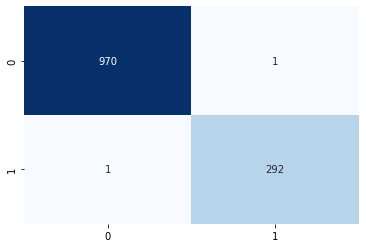

In [ ]:
cm = confusion_matrix(Y_test, y_pred_xgb)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

In [ ]:
print("XGBoost evaluation\n")

ac=accuracy_score(Y_test, y_pred_xgb)
ps = precision_score(Y_test, y_pred_xgb)
rs = recall_score(Y_test, y_pred_xgb)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

XGBoost evaluation

accuracy of the model:  0.9984177215189873
precision score of the model:  0.9965870307167235
recall score of the model:  0.9965870307167235


# **Random Forest**

Random Forest е вид на supervised learning алгоритам. Гради Шума на Дрва на одлучување и ги спојува за да добие попрецизно и стабилно предвидување.


Одбираме поголем број за n_estimators 1000 со цел да имаме постабилни предикции и да ги зголемиме перформансите.


Поставуваме вредност за random state od 42, што помага излезот на моделот да се реплицира/повторува, т.е ќе ги враќа секогаш истите резултати кога има одредена вредност за random state и ако му се дадени истите хиперпараметри и истите податоци при training. 

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)
data_encoded.head()

,type,title,director,cast,date_added,rating,description,isAdult,startYear,endYear,country,duration,averageRating,numVotes
0,0,90,1470,1130,703,8,1004,0,64,33,39,89,43,554
1,0,50,1034,4384,586,5,5003,0,59,33,57,74,30,773
2,0,91,2728,1277,382,4,2780,0,57,33,71,76,55,3527
3,0,91,2728,1277,382,4,2780,0,57,33,71,76,38,85
4,0,45,2518,2086,36,4,97,0,56,33,71,119,52,3660


In [ ]:
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

In [ ]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

In [ ]:
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
feature_list = list(X.columns)
feature_list

['title',
 'director',
 'cast',
 'date_added',
 'rating',
 'description',
 'isAdult',
 'startYear',
 'endYear',
 'country',
 'duration',
 'averageRating',
 'numVotes']

In [ ]:
# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

In [ ]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 4


In [ ]:
y_pred_rf = model.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       971
           1       1.00      0.97      0.98       293

    accuracy                           0.99      1264
   macro avg       0.99      0.99      0.99      1264
weighted avg       0.99      0.99      0.99      1264



In [ ]:
print("Random Forest Regressor evaluation\n")

ac=accuracy_score(Y_test, y_pred_rf)
ps = precision_score(Y_test, y_pred_rf)
rs = recall_score(Y_test, y_pred_rf)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

Random Forest Regressor evaluation

accuracy of the model:  0.992879746835443
precision score of the model:  0.9965034965034965
recall score of the model:  0.9726962457337884


# **Linear Regresion**

Предикторите имаат нормална распределба. Излезот Y е од непрекинат тип. Постои линеарна врска помеѓу влезните променливи и излезот. Податоците се независни едни од други.

In [ ]:
data_encoded = netflix.apply(LabelEncoder().fit_transform)

In [ ]:
X = data_encoded.drop(['duration'], axis = 1)
Y = data_encoded.duration.values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = LinearRegression().fit(X_train, Y_train)

In [ ]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
type,-38.110756
title,0.621684
director,-0.275598
cast,-0.754968
date_added,-0.133990
rating,-3.401381
description,-0.506001
isAdult,0.121552
startYear,-3.625107
endYear,0.932854


In [ ]:
y_pred = model.predict(X_test)

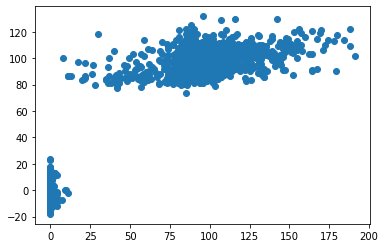

In [ ]:
plt.scatter(Y_test, y_pred)

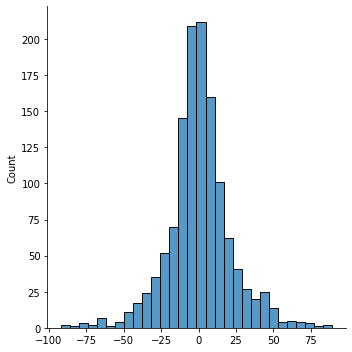

In [ ]:
sns.displot((Y_test - y_pred), bins=30)

In [ ]:
print('MAE: ', metrics.mean_absolute_error(Y_test, y_pred))
print('MSE: ', metrics.mean_squared_error(Y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))

MAE:  14.980865384406291
MSE:  452.1578481830277
RMSE:  21.264003578419274


In [ ]:
r_sq = model.score(X_train, Y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7957568643647283


In [ ]:
np.set_printoptions(formatter={'float_kind':'{:2f}'.format})

In [ ]:
X = data_encoded.rating.values
Y = data_encoded.duration.values

In [ ]:
poly = PolynomialFeatures(3, include_bias=False)
x_np = np.array(X)
poly.fit_transform(x_np[:, None])

array([[8.000000, 64.000000, 512.000000],
       [5.000000, 25.000000, 125.000000],
       [4.000000, 16.000000, 64.000000],
       ...,
       [8.000000, 64.000000, 512.000000],
       [6.000000, 36.000000, 216.000000],
       [8.000000, 64.000000, 512.000000]])

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(8), LinearRegression())
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)

xfit = np.linspace(min(X), max(X), 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

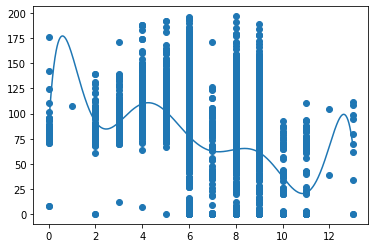

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

# **LASSO**

least absolute shrinkage and selection operator ( lasso) е регресивен анализички метод кој врши и селекција на променливи и регулација на редоследот за да се подобри точноста и разбирливоста на статичкото добиено решение
Лассо има тенденција да работи добро ако има мал број значајни параметри, а другите се блиску до нула (пр: кога само неколку предиктори всушност влијаат на одговорот).
Лассо првично бил формулиран за модели на линеарна регресија. Иако имал друга намена лассо лесно се проширил до други статички модели вклучувајќи генерализирани линеарни модели, генерализирани равенки за проценка, модели на пропорционални опасности и М-estimators.
Способноста на Ласо да изврши избор на подмножества се потпира на формата на ограничувањето, и има разновидни толкувања, вклучително и во однос на геометријата, Бајезијанската статистика и конвексната анализа.

In [ ]:
model = Lasso(alpha=0.0001)
model.fit(X[:, np.newaxis],Y)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
print(model.intercept_)

130.99142622093981


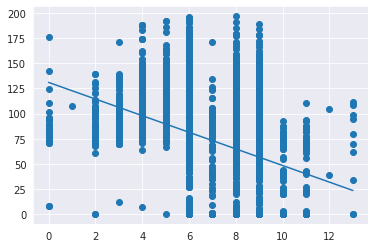

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

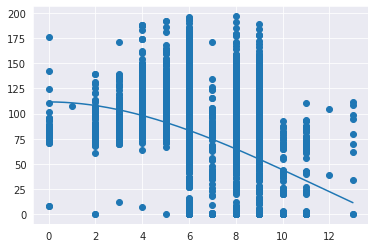

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(3), Lasso(alpha=1))
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(X, Y)
plt.plot(xfit, yfit)

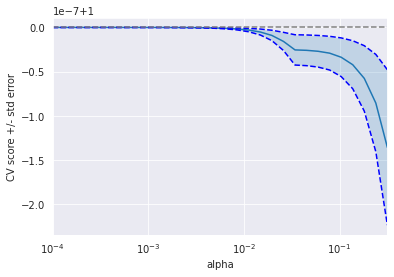

In [ ]:
X = data_encoded[:150]
Y = data_encoded[:150]

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parametars = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parametars, cv=n_folds, refit=False)
clf.fit(X,Y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.show()

# **RIDGE**

RIDGE е модел на подесување метод кој се користи за анализа на сите податоци што страдаат од мултиколинеарност.
RDIGE  била развиена како можно решение за непрецизноста на најмалку квадратни проценители кога линеарните регресивни модели имаат некои повеќеколинеарни  независни променливи - преку создавање проценител на регресионен гребен (resgression estimator) (RR). Ова обезбедува попрецизна проценка на параметрите на гребенот(ridge), бидејќи неговата варијанса и просечен квадратен проценител честопати се помали од претходно проценетите најмалку проценувачи на квадрат.

In [ ]:
X = data_encoded.rating.values
Y = data_encoded.duration.values

In [ ]:
model = Ridge(alpha=0.001)
model.fit(X[:, np.newaxis], Y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
print(model.intercept_)

131.08621981419657


In [ ]:
yfit = model.predict(xfit[:, np.newaxis])

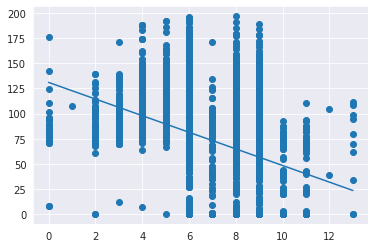

In [ ]:
plt.scatter(X, Y)
plt.plot(xfit, yfit)

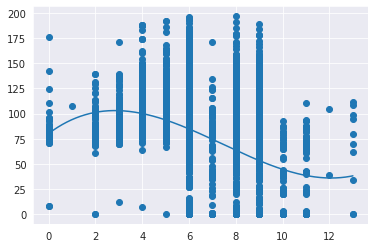

In [ ]:
poly_model = make_pipeline(PolynomialFeatures(3), Ridge(alpha=0.001))
X = np.array(X)
poly_model.fit(X[:, np.newaxis], Y)
yfit = poly_model.predict(xfit[:, np.newaxis])
plt.scatter(X, Y)
plt.plot(xfit, yfit)

# **Elastic Net Regression**

Избираме вредност за алфа 0.0005 и l1_ratio 0.9 со што добиваме вредност за r2 score од ~ 0,75 што значи дека податоците се добро сместени.

In [73]:
X = data_encoded.drop(['duration'], axis = 1)
Y = data_encoded.duration.values

In [74]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha= 0.0005, l1_ratio=.9, random_state=3))
ENet.fit(X, Y)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=3,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

In [75]:
y_pred_en = ENet.predict(X)

In [77]:
print("r2 score of Elastic Net: ",r2_score(y_pred_en, Y))

r2 score of Elastic Net:  0.7708301896741097


# **Logistic Regression**

Логистичка регресија дава бинарен одговор каде што имаме две зависни променливи со вредности 0 или 1 (tv show/movie). 

In [38]:
data_encoded = data.apply(LabelEncoder().fit_transform)

In [39]:
X = data_encoded.drop(['type'], axis = 1)
Y = data_encoded.type.values

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [41]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
y_pred = model.predict(X_test)

In [43]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1079
           1       1.00      1.00      1.00       479

    accuracy                           1.00      1558
   macro avg       1.00      1.00      1.00      1558
weighted avg       1.00      1.00      1.00      1558



In [44]:
print("Logistic Regression evaluation\n")

ac=accuracy_score(Y_test, y_pred)
ps = precision_score(Y_test, y_pred)
rs = recall_score(Y_test, y_pred)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

Logistic Regression evaluation

accuracy of the model:  0.9993581514762516
precision score of the model:  0.9979166666666667
recall score of the model:  1.0


(array([1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 4.00e+00, 1.55e+03]),
 array([0.73557997, 0.76202197, 0.78846398, 0.81490598, 0.84134798,
        0.86778999, 0.89423199, 0.92067399, 0.94711599, 0.973558  ,
        1.        ]),
 <a list of 10 Patch objects>)

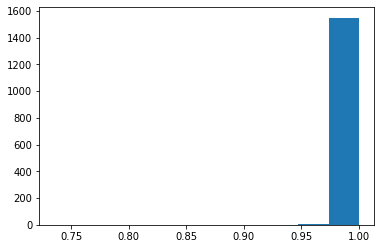

In [45]:
y_pred_proba = model.predict_proba(X_test)
plt.hist([max(x) for x in y_pred_proba])

In [46]:
y_pred_proba

array([[1.63894833e-06, 9.99998361e-01],
       [1.00000000e+00, 9.97257256e-48],
       [1.64257620e-02, 9.83574238e-01],
       ...,
       [1.00000000e+00, 2.32645677e-33],
       [1.00000000e+00, 9.59841881e-39],
       [9.56751717e-06, 9.99990432e-01]])

# **LDA**

In [47]:
X = data_encoded.drop(['type'], axis = 1)
Y = data.type.values
target_names = data.type

explained variance ratio : [0.39754836 0.23764822]


Text(0.5, 1.0, 'LDA of Netflix dataset')

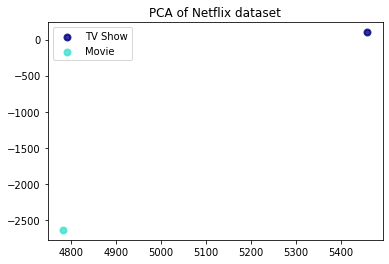

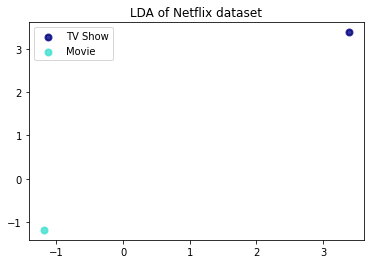

In [48]:
pca = PCA(n_components = 2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, Y).transform(X)

print('explained variance ratio : %s' %str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0,1], target_names):
  plt.scatter(X_r[i, 0], 
              X_r[i, 1], 
              color = color, 
              alpha=0.8, lw=lw,
              label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Netflix dataset')

plt.figure()
for color, i, target_name in zip(colors, [0,1], target_names):
  plt.scatter(X_r2[i], 
              X_r2[i], 
              color = color, 
              alpha=0.8, lw=lw,
              label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of Netflix dataset')


# **Kmeans**

Тип на парцијално кластерирање. Центроид најчесто претставува средна вредност на точките во кластерот. Секоја точка е распределена според најблискиот центроид.

Ги трансформираме и скалираме податоците за да можеме да го изградиме моделот.

In [49]:
data = netflix[['type', 'duration','startYear']].copy()

In [50]:
le = LabelEncoder()
data['type'] = le.fit_transform(data.type.values)

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [52]:
data

array([[0.        , 0.29581994, 0.93670886],
       [0.        , 0.24758842, 0.87341772],
       [0.        , 0.25401929, 0.84810127],
       ...,
       [0.        , 0.31511254, 0.79746835],
       [0.        , 0.35369775, 0.92405063],
       [0.        , 0.28617363, 0.97468354]])

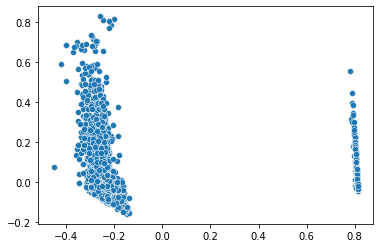

In [53]:
pca = PCA(n_components=2)
data_pca = pca.fit(data).transform(data)
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1])
plt.show()

Правиме функција за KMeans, ставаме вредност за max iterations од 50 (тоа е максималениот број повторувања на алгоритмот kmeans за едно извршување). За random state stavame 1 (колку пати ќе се иницијализираат центроидот/ите).

In [54]:
def k_means(data, n_clusters):
  k_means = KMeans(n_clusters=n_clusters, max_iter=50, random_state=1)
  k_means.fit(data)
  labels = k_means.labels_
  centroids = k_means.cluster_centers_
  pd.DataFrame(centroids)

  sns.scatterplot(x=data[:,0], y=data[:,1], hue=labels)
  sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker="*",  s=500)
  plt.show()

Ја повикуваме функцијата со 2 кластери.

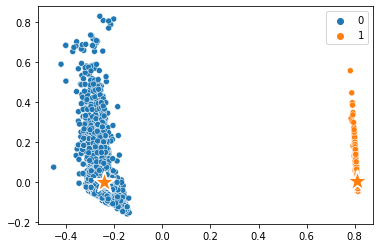

In [55]:
k_means(data_pca, 2)

Со зголемување на бројот на кластери се намалува SSE, затоа избираме вредност за k од 2, со графикот гледаме дека кај двојката престанува драстично да паѓа SSE (sum of squared error).

Text(0, 0.5, 'SSE')

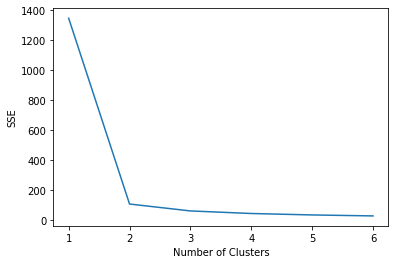

In [56]:
numClusters = 7
SSE = []
silhouette_coef = []
for k in range(1, numClusters):
  k_means = KMeans(n_clusters=k)
  k_means.fit(data)
  SSE.append(k_means.inertia_)
  if k<=1:
    continue
  score = silhouette_score(data, k_means.labels_)
  silhouette_coef.append(score)

plt.plot(range(1, numClusters),SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

# **Agglomerative Clustering**

Агломеративното кластерирање е вид на хиерархиско кластерирање каде рекурзивно се спојуваат пар кластери од множеството на податоци.

Избираме default вредност за n_clusters што е 2.

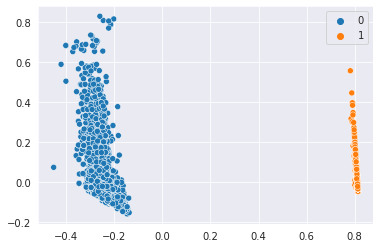

In [ ]:
ac = AgglomerativeClustering(n_clusters=2).fit(data_pca)

sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=ac.labels_)
plt.show()

In [ ]:
print(ac.n_clusters_)
print(ac.n_connected_components_)

2
1


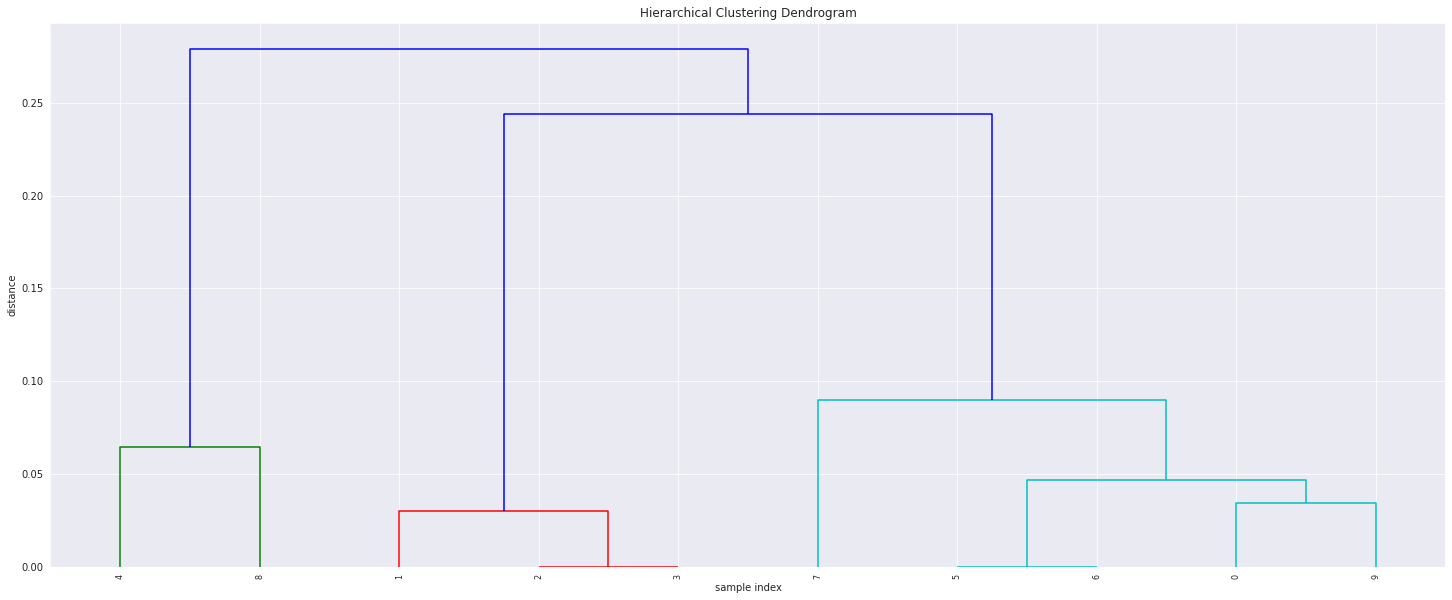

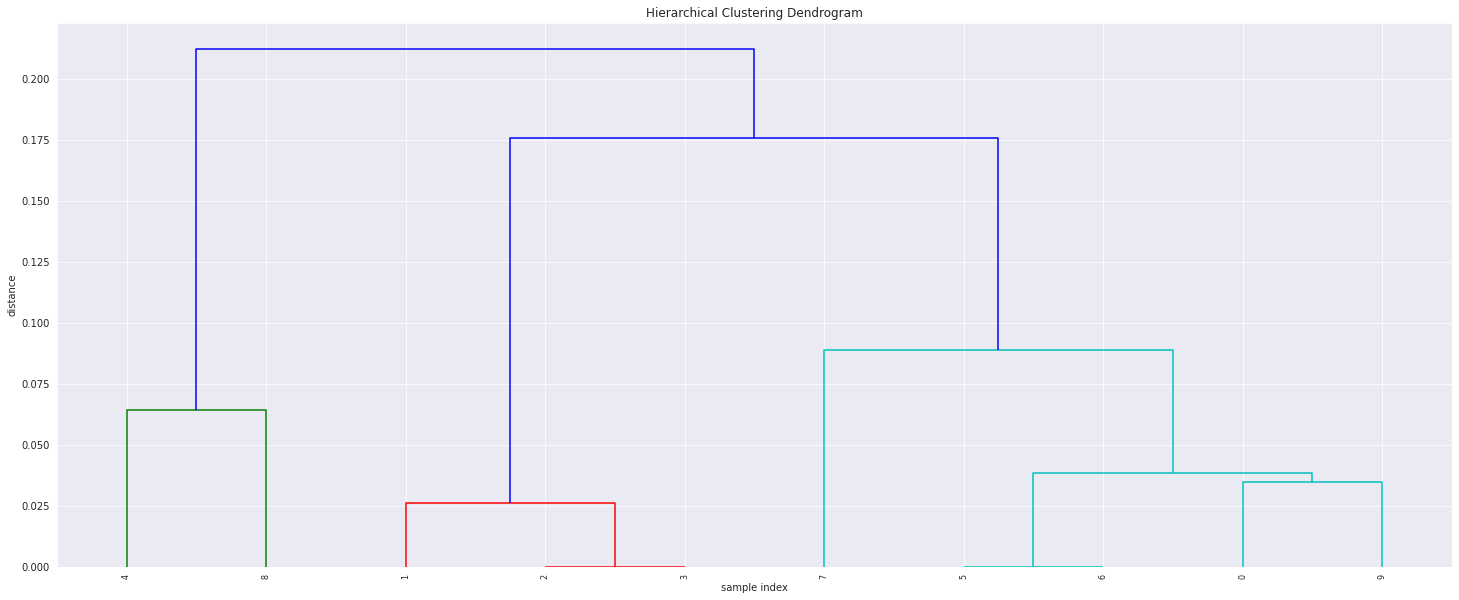

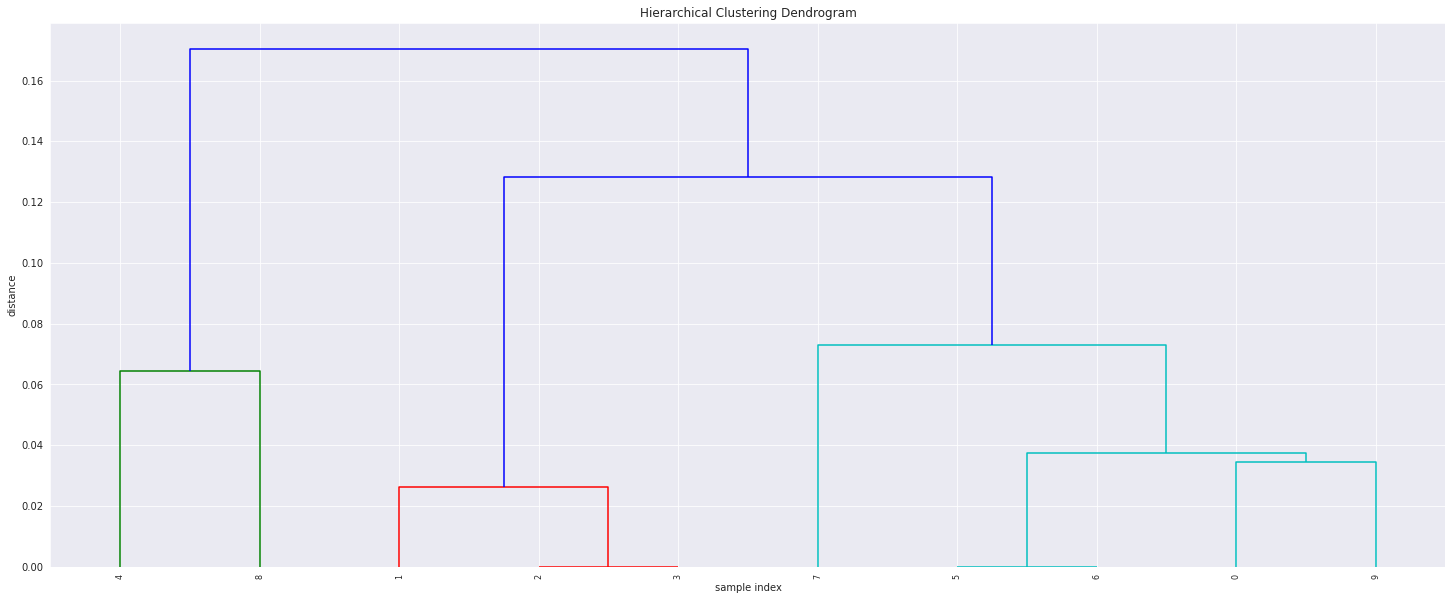

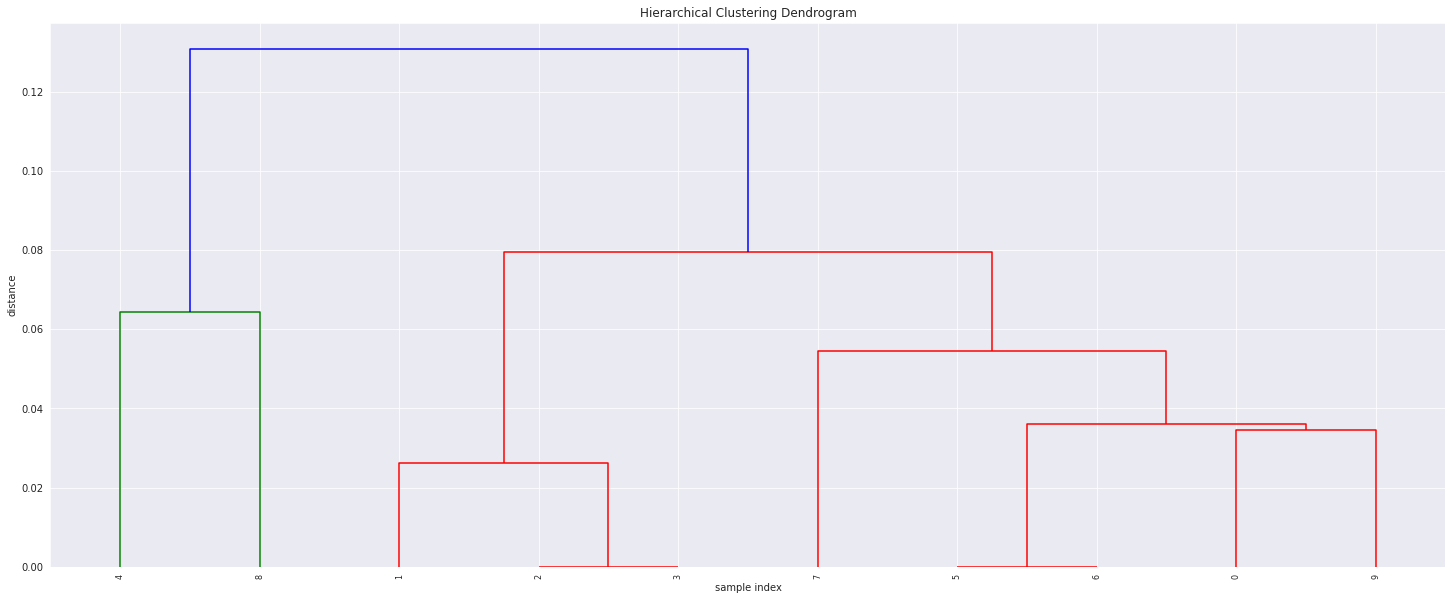

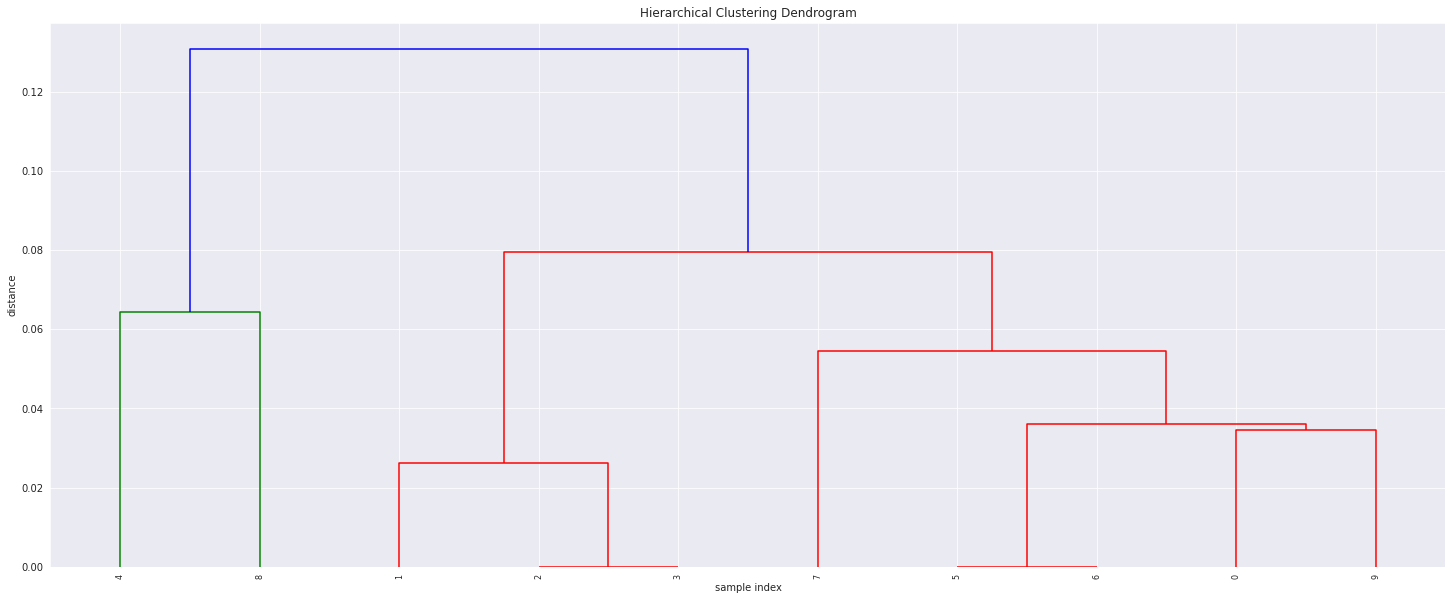

In [ ]:
linkage_types = ['ward', 'complete', 'average', 'single']
for link_type in linkage_types:
  Z = linkage(data[:10], link_type)
  
  plt.figure(figsize=(25, 10))
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('sample index')
  plt.ylabel('distance')

  dendrogram(Z, leaf_rotation=90., leaf_font_size=8.);
  plt.show();

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp');

# **DBSCAN**

DBSCAN пронаоѓа основни примероци со висока густина и ги проширува кластерите од нив. Добро за податоци што содржат кластери со слична густина.

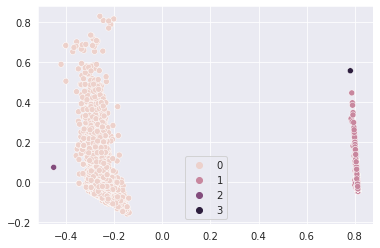

In [ ]:
db = DBSCAN(eps=0.1, min_samples=1).fit(data_pca)

sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=db.labels_)

plt.show()

# **Affinity Propagation**

Affinity propagation е вид на unsupervised machine learning алгоритам кој е особено прилагоден за проблеми каде што не го знаеме оптималниот број на кластери, и затоа се користи најчесто кога не знаеме која вредност да ја ставиме за број на кластери. 


default вредност за damping е 0.5, но не ни даде задоволителни резултати и со пробување дојдовме до овој број. Damping factor е во ранг од 0.5 до 1, и тоа е степенот до кој сегашната вредност се одржува во однос на влезните параметри, се користи за да се избегнат нумерички осцилации при ажурирање на вредностите.

In [66]:
ap = AffinityPropagation(damping=0.9).fit(data_pca)

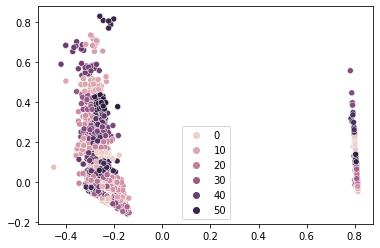

In [67]:
sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=ap.labels_)

plt.show()

# **Birch**

Конструира дрво, каде што центроидите на кластерите се читаат од листот, овие можат да бидат или конечни кластери или може да се дадат како влез во друг алгоритам за кластерирање како што е агломеративното кластерирање.

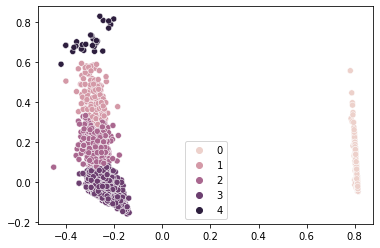

In [ ]:
b = Birch(threshold=0.01, n_clusters=5).fit(data_pca)

sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=b.labels_)

plt.show()

# **Spectral Clustering**

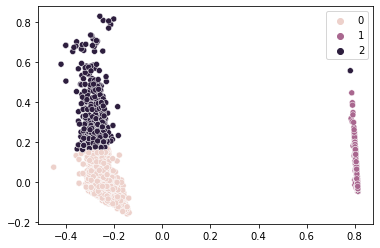

In [ ]:
sc = SpectralClustering(n_clusters=3).fit(data_pca)

sns.scatterplot(x=data_pca[:,0], y=data_pca[:,1], hue=sc.labels_)

plt.show()